# Aprendizado profundo com Python

## 8.4 Gerando imagens com autoencoders variacionais

> Gerar imagem com autoencoder variacional

O DeepDream e o Neural Style Transfer introduzidos nos dois primeiros artigos limitaram apenas a "modificação" de trabalhos existentes. O GAN e o VAE que vamos apresentar a seguir são mais criativos.As duas técnicas extraem amostras do espaço latente da imagem e criam uma nova imagem ou editam uma imagem existente.

-VAE: Variational AutoEncoder (Variational AutoEncoder)
-GAN: Generative Adversarial Network


### Amostragem do espaço latente

O espaço latente é um espaço vetorial no qual qualquer ponto pode ser mapeado para uma imagem realista. O módulo que implementa este mapeamento (ponto potencial -> imagem) é o gerador de GAN, ou decodificador de VAE.

A chave para GAN e VAE gerar imagens é encontrar um "espaço latente de representações" de baixa dimensão. Uma vez que esse espaço latente é encontrado, amostrado a partir dele e mapeado para o espaço da imagem, uma nova imagem pode ser gerada.



Há uma grande diferença no espaço potencial da aprendizagem GAN e VAE:

-VAE é bom em aprender um espaço latente bem estruturado, no qual uma direção específica pode codificar (representar) um eixo significativo de mudança nos dados.
-As imagens geradas pelo GAN podem ser muito realistas, mas o espaço latente carece de boa estrutura e continuidade insuficiente.


### Vetor de conceito

Vetor de conceito: dado um espaço latente ou espaço de incorporação, uma direção específica no espaço pode representar um eixo significativo de mudança nos dados originais. Por exemplo, para uma imagem, pode haver um vetor representando o conceito de "sorriso" no espaço latente de uma imagem de rosto (chamado de vetor de sorriso): para um ponto potencial z que representa um certo rosto, z + s é a mesma pessoa A expressão com um sorriso no rosto.

Depois de encontrar esses vetores de conceito, podemos usar este método para editar a imagem: projetar a imagem no espaço latente, realizar operações com o vetor de conceito para mover sua representação e, em seguida, decodificá-lo no espaço da imagem para alterar a imagem Um certo conceito de - como o grau de sorriso:


### Codificador Variacional

O autocodificador é um tipo de rede que recebe uma imagem, mapeia-a para o "espaço potencial" através do módulo codificador e a decodifica em uma saída com o mesmo tamanho da imagem original através do módulo decodificador. O objetivo de treinar isso é tornar a saída igual à entrada, então usamos a mesma imagem para a entrada e saída. Portanto, o que o codificador automático aprende é reconstruir a entrada original.


O autoencoder variacional VAE é um autoencoder moderno. É um modelo generativo, especialmente para tarefas de edição de imagens usando vetores conceituais. Comparado com os autoencoders clássicos, VAE pode aprender um espaço latente mais contínuo e altamente estruturado.

VAE não compacta a imagem de entrada em um código fixo no espaço latente, mas converte a imagem em parâmetros de distribuição estatística - média e variância. Quando VAE decodifica, ele usa o valor médio e a variância para amostrar aleatoriamente um elemento da distribuição e decodificar esse elemento para a entrada original. Portanto, o processo de codificação / decodificação do VAE é um tanto aleatório.

A aleatoriedade desse processo melhora a robustez do espaço latente VAE: VAE precisa garantir que cada ponto amostrado no espaço latente possa ser decodificado em uma saída válida, o que força qualquer posição no espaço latente a corresponder a uma representação significativa.


A figura acima mostra o princípio de funcionamento do VAE:

1. O módulo Encoder converte a amostra de entrada `input_img` nos parâmetros` z_mean` e `z_log_variance` no espaço latente;
2. Faça uma amostra aleatória de um ponto z desta distribuição normal potencial: `z = z_mean + exp (z_log_variance) * epsilon`, onde epsilon é um tensor aleatório com um valor pequeno;
3. O módulo decodificador mapeia este ponto potencial de volta à imagem de entrada original.

epsilon é aleatório, então cada ponto que precisa estar próximo à posição potencial (média z) codificada por input_img pode ser decodificado em uma imagem semelhante a input_img. Esta propriedade força o espaço potencial a ser continuamente significativo: quaisquer dois no espaço potencial Todos os pontos adjacentes serão decodificados em imagens altamente semelhantes. A continuidade e a baixa dimensionalidade do espaço latente forçam cada direção no espaço latente a representar um eixo significativo de mudança nos dados, de modo que as operações possam ser realizadas por meio de vetores conceituais.

O pseudocódigo para implementar VAE com Keras é o seguinte:

`` `python
z_mean, z_log_variance = encoder (input_img)
z = z_mean + exp (z_log_variance) * epsilon
reconstructed_img = decoder (z)
model = Model (input_img, reconstruced_img)
`` `

O treinamento VAE requer duas funções de perda:

- Perda de reconstrução: fazer com que as amostras decodificadas correspondam à entrada inicial;
- Perda de regularização (perda de regularização): Faz com que o espaço latente tenha uma boa estrutura (continuidade, disponibilidade do vetor conceito), mas também reduza o sobreajuste nos dados de treinamento;


Implementamos especificamente a rede do codificador: por meio de uma rede neural convolucional, a imagem de entrada x é mapeada em dois vetores z_mean e z_log_var.

In [10]:
# Não use o modo de execução just-in-time

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [11]:
# VAE Rede codificadora

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2    # Dimensões do espaço latente: plano 2D

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


O código a seguir usará z_mean e z_log_var para gerar (amostra) um ponto de espaço latente z.

In [12]:
# Função de amostragem do espaço latente

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])    # Empacotar como camada

Em seguida, há a realização do decodificador: o tamanho do vetor z é ajustado ao tamanho da imagem e, em seguida, várias camadas convolucionais são usadas para obter a saída final da imagem.

In [13]:
# VAE Rede decodificadora

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

VAE precisa de duas perdas, então não pode ser escrito diretamente como `perda (entrada, destino)`. Precisamos escrever uma camada personalizada na qual o método embutido `add_loss` é usado para criar a perda necessária.

In [14]:
# Camada personalizada para calcular a perda VAE

class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
            axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

Por fim, instancie o modelo e comece o treinamento. Uma vez que nossa perda está incluída na camada personalizada, não há necessidade de especificar a perda externa (`perda = Nenhum`) ao compilar, portanto, não há necessidade de dados de destino especificados externamente (` y = Nenhum`).

Aqui usamos MNIST para treiná-lo, que é para gerar o espaço latente de dígitos escritos à mão.

In [15]:
from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
_______________________________________________________________________________________

Depois de treinar o modelo, podemos usar o decodificador para converter qualquer vetor no espaço latente em uma imagem.

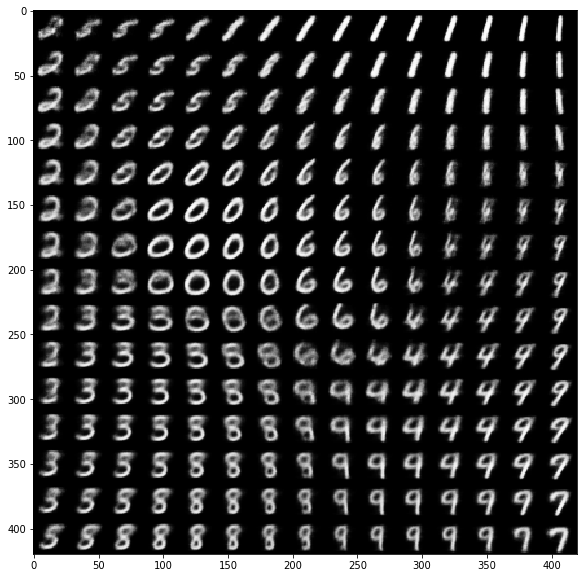

In [18]:
# Faça uma amostra de um conjunto de pontos do espaço latente e decodifique-o em uma imagem

import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15    # Exibir números 15x15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) # função ppf transforma coordenadas separadas linearmente para gerar o valor da variável latente z
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_simple = np.array([[xi, yi]])
        z_simple = np.tile(z_simple, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_simple, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()